# Autoencoder Development

#### 1. Dependencies

This section could include:
* Library imports.
* Constant definitions

In [17]:
import matplotlib.pyplot as plt
import math
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader
import gc
import time
from IPython.display import clear_output
import cv2

In [18]:
gpu_available = torch.cuda.is_available()

if gpu_available:
    DEVICE = torch.device("cuda")
else:
    DEVICE = torch.device("cpu")

global STRIDE, KERNEL_SIZE
INPUT_SIZE = 3
LATENT_SIZE = 1024
KERNEL_SIZE = 5
STRIDE = 5
PADDING = 0

#### 2. Data Loading & Feature Engineering

This section could include:

* Loading of data files
* Data manipulation
* Feature engineering strategies

In [19]:
images = np.load("subset_1.npy")

padded_images = []

for i in range(len(images)):
    img = np.reshape(images[i], (150, 225, 3))
    padded = cv2.copyMakeBorder(img, 1, 1, 3, 4, borderType = cv2.BORDER_CONSTANT, value = [0, 0, 0])
    padded_images.append(padded)

images = np.array(padded_images)


num_images = images.shape[0]
training_samples = int((0.75 * num_images) // 1)
# batch_size = math.ceil(training_samples / 10)

images = images.reshape(-1, 3, 152, 232)
np.random.shuffle(images)

train_data = images[:training_samples] / 255.
test_data = images[training_samples:] / 255.

train_data = torch.tensor(train_data, dtype = torch.float32)
test_data = torch.tensor(test_data, dtype = torch.float32)

# train_dataset = TensorDataset(train_data)
# test_dataset = TensorDataset(test_data)

# train_loader = DataLoader(dataset = train_dataset, batch_size = batch_size, shuffle = True)
# test_loader = DataLoader(dataset = test_dataset, batch_size = 1, shuffle = False)

#### 3. Model Development

This section could include:

* Model Definitions
* Hyperparameter Tuning
* Training code
* Optimisation

In [ ]:
# Handles creation of encoder and decoder
class Autoencoder(nn.Module):
    def __init__(self, encoder, layers):
        super(Autoencoder, self).__init__()
        self.encoder = encoder
        self.layers = layers
        self.num_layers = len(layers)

        self.layer_data = self.detect_function()
        if self.encoder:
            self.encode = self.create_model()
            self.encode.to(DEVICE)
        else:
            self.decode = self.create_model()
            self.decode.to(DEVICE)


    def detect_function(self):
        self.k = 5
        self.s = 5
        layer_data = []
        previous_node_count = INPUT_SIZE if self.encoder else LATENT_SIZE
        self.last_layer = False
        self.c = 1

        for layer in self.layers:
            a_func, nodes = layer[0], layer[1]
            a_func = a_func.lower()

            if self.c == len(self.layers) and self.encoder:
                self.last_layer = True

            if self.last_layer:
                self.k = 3
                self.s = 3
            if self.encoder:
                layer_data.append(nn.Conv2d(in_channels = previous_node_count, out_channels = nodes, kernel_size = self.k, stride = self.s, padding = PADDING))
            else:
                layer_data.append(nn.ConvTranspose2d(in_channels = previous_node_count, out_channels = nodes, kernel_size = self.k, stride = self.s, padding = PADDING))

            previous_node_count = nodes

            # if not self.last_layer:
            match a_func:
                case "relu":
                    layer_data.append(nn.ReLU())
                case "lrelu":
                    layer_data.append(nn.LeakyReLU(0.01))
                case "sigmoid":
                    layer_data.append(nn.Sigmoid())
                case "tanh":
                    layer_data.append(nn.Tanh())
                case _:
                    layer_data.append(nn.ReLU())

            self.c += 1
        return layer_data
        
    def create_model(self):
        # model = nn.Sequential(*self.layer_data)
        if self.encoder:
            model = nn.Sequential(
                nn.Conv2d(in_channels = 3, out_channels = 64, kernel_size = 2, stride = 2, padding = 0),
                nn.LeakyReLU(0.01),

                nn.Conv2d(in_channels = 64, out_channels = 256, kernel_size = 2, stride = 2, padding = 0),
                nn.LeakyReLU(0.01),

                nn.Conv2d(in_channels = 256, out_channels = 512, kernel_size = 2, stride = 2, padding = 0),
            )
        else:
            model = nn.Sequential(
                nn.ConvTranspose2d(in_channels = 512, out_channels = 256, kernel_size = 2, stride = 2, padding = 0),
                nn.LeakyReLU(0.01),

                nn.ConvTranspose2d(in_channels = 256, out_channels = 64, kernel_size = 2, stride = 2, padding = 0),
                nn.LeakyReLU(0.01),

                nn.ConvTranspose2d(in_channels = 64, out_channels = 3, kernel_size = 2, stride = 2, padding = 0),
                nn.Sigmoid()
            )
        
        return model

    def enc(self, x):
        return self.encode(x)
    
    def dec(self, x):
        return self.decode(x)


#### 4. Model Evaluation

This section could include:

* Testing of models trained
* Generation of results

In [21]:
# Handels autoencoder training
class AutoencoderTrainer:
    def __init__(self, encoder, decoder, learning_rate):
        self.encoder = encoder
        self.decoder = decoder
        self.learning_rate = learning_rate
        self.loss_f = nn.MSELoss()
        self.optimizer = torch.optim.Adam(list(encoder.parameters()) + list(decoder.parameters()), lr = self.learning_rate)

    def autoencode(self, encoder, decoder, data):
        return decoder.dec(encoder.enc(data))

    def calculate_loss(self, output, target):
        loss = self.loss_f(output, target)
        return loss
    
    def update(self, loss):
        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()

    def train(self, epochs):
        for epoch in range(1, epochs + 1):
            for sample in train_data:
                sample = sample.to(DEVICE)
                output = self.autoencode(self.encoder, self.decoder, sample)  
                
                loss = self.calculate_loss(output, sample)
                self.update(loss)

            print(f"Epoch: {epoch}, Loss: {loss.item()}")

    def test(self):
        outputs = []
        for sample in test_data:
            sample = sample.to(DEVICE)
            output = self.autoencode(self.encoder, self.decoder, sample)
            outputs.append(output)

        return outputs

In [22]:
encoder_layer_data = [
    ("lrelu", 128),
    ("lrelu", 256),
    ("lrelu", 512),
]

decoder_layer_data = [
    ("lrelu", 256),
    ("lrelu", 128),
    ("sigmoid", 3),
]

encoder = Autoencoder(True, encoder_layer_data)
decoder = Autoencoder(False, decoder_layer_data)

trainer = AutoencoderTrainer(encoder, decoder, 0.0001) # 40, 0.0001
trainer.train(50)

Epoch: 1, Loss: 0.021692071110010147
Epoch: 2, Loss: 0.014348839409649372
Epoch: 3, Loss: 0.007329162210226059
Epoch: 4, Loss: 0.004349231719970703
Epoch: 5, Loss: 0.00365825486369431
Epoch: 6, Loss: 0.0031932182610034943
Epoch: 7, Loss: 0.0028761986177414656
Epoch: 8, Loss: 0.0026695679407566786
Epoch: 9, Loss: 0.0025185029953718185
Epoch: 10, Loss: 0.002394014038145542
Epoch: 11, Loss: 0.0022828879300504923
Epoch: 12, Loss: 0.0021833789069205523
Epoch: 13, Loss: 0.0020893034525215626
Epoch: 14, Loss: 0.001998424995690584
Epoch: 15, Loss: 0.001907172380015254
Epoch: 16, Loss: 0.0018184416694566607
Epoch: 17, Loss: 0.0017358590848743916
Epoch: 18, Loss: 0.0016570159932598472
Epoch: 19, Loss: 0.001584935700520873
Epoch: 20, Loss: 0.0015213866718113422
Epoch: 21, Loss: 0.001462276210077107
Epoch: 22, Loss: 0.0014062999980524182
Epoch: 23, Loss: 0.0013558834325522184
Epoch: 24, Loss: 0.0013040321646258235
Epoch: 25, Loss: 0.001264828722923994
Epoch: 26, Loss: 0.0012238554190844297
Epoch: 

In [23]:
print(encoder)
print(decoder)

Autoencoder(
  (encode): Sequential(
    (0): Conv2d(3, 64, kernel_size=(2, 2), stride=(2, 2))
    (1): LeakyReLU(negative_slope=0.01)
    (2): Conv2d(64, 256, kernel_size=(2, 2), stride=(2, 2))
    (3): LeakyReLU(negative_slope=0.01)
    (4): Conv2d(256, 512, kernel_size=(2, 2), stride=(2, 2))
  )
)
Autoencoder(
  (decode): Sequential(
    (0): ConvTranspose2d(512, 256, kernel_size=(2, 2), stride=(2, 2))
    (1): LeakyReLU(negative_slope=0.01)
    (2): ConvTranspose2d(256, 64, kernel_size=(2, 2), stride=(2, 2))
    (3): LeakyReLU(negative_slope=0.01)
    (4): ConvTranspose2d(64, 3, kernel_size=(2, 2), stride=(2, 2))
    (5): Sigmoid()
  )
)


#### 5. Figure Creation

This section could include:

* Creation of figures for the report.
* Creationg of tables for the report.

In [24]:
imgs = trainer.test()

for i in range(len(imgs)):
    imgs[i] = (imgs[i].detach().cpu().numpy() * 255).astype(np.uint8)
    imgs[i] = np.reshape(imgs[i].flatten(), (152, 232, 3))
    
    

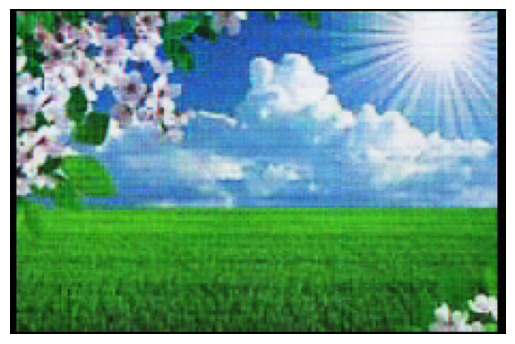

[63, 90, 7, 69, 49]


In [31]:
image_indexes = []
for i in range(5):
    num = np.random.randint(0, len(test_data) - 1)
    image_indexes.append(num)
    clear_output(wait = True)
    plt.imshow(np.reshape((test_data[num].numpy() * 255).astype(np.uint8), (152, 232, 3)))
    plt.axis("off")
    plt.show()
    time.sleep(1)
    clear_output(wait = True)
    plt.imshow(imgs[num])
    plt.axis("off")
    plt.show()
    time.sleep(1)
print(image_indexes)

In [26]:
IMAGE_NUMBER = 10

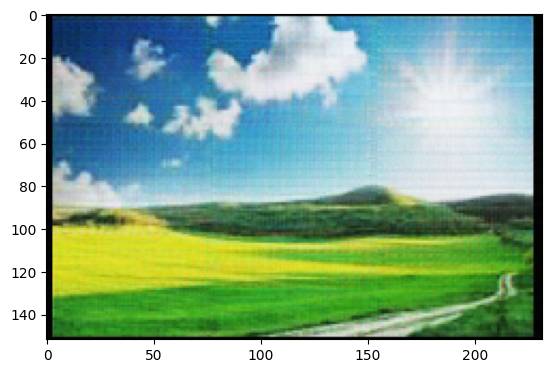

In [27]:
plt.imshow(imgs[IMAGE_NUMBER])

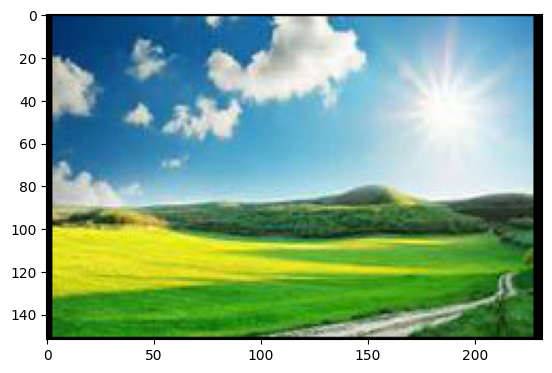

In [28]:
plt.imshow(np.reshape((test_data[IMAGE_NUMBER].numpy() * 255).astype(np.uint8), (152, 232, 3)))

In [29]:
# gc.collect()
# torch.cuda.empty_cache()
# torch.cuda.synchronize()

In [30]:
# 500 epochs, 0.00001 lr
# Autoencoder(
#   (encode): Sequential(
#     (0): Conv2d(3, 64, kernel_size=(2, 2), stride=(2, 2))
#     (1): LeakyReLU(negative_slope=0.01)
#     (2): Conv2d(64, 256, kernel_size=(2, 2), stride=(2, 2))
#     (3): LeakyReLU(negative_slope=0.01)
#     (4): Conv2d(256, 512, kernel_size=(2, 2), stride=(2, 2))
#   )
# )
# Autoencoder(
#   (decode): Sequential(
#     (0): ConvTranspose2d(512, 256, kernel_size=(2, 2), stride=(2, 2))
#     (1): LeakyReLU(negative_slope=0.01)
#     (2): ConvTranspose2d(256, 64, kernel_size=(2, 2), stride=(2, 2))
#     (3): LeakyReLU(negative_slope=0.01)
#     (4): ConvTranspose2d(64, 3, kernel_size=(2, 2), stride=(2, 2))
#     (5): Sigmoid()
#   )
# )

# encoder_parameters = torch.save(encoder.encode.state_dict(), "encoder_parameters.pth")
# decoder_parameters = torch.save(decoder.decode.state_dict(), "decoder_parameters.pth")